# Laplace–Beltrami

In [39]:
import pyvista as pv
from pyvista.plotting import Plotter
import numpy as np
from scipy.sparse import lil_matrix, diags
from scipy.sparse.linalg import eigsh # Za svojstvene vrijednosti/vektore simetričnih rijetkih matrica
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from nilearn import datasets
import trimesh
import trimesh.smoothing
import numpy as np
from scipy.sparse.linalg import eigs
import nibabel as nib
import os

Backend postavljen na 'static'.
Informacije o učitanoj mreži:
  Broj vrhova: 1202
  Broj ćelija (ploha): 2256
  Ograničavajući okvir (bounds): BoundsTuple(x_min=-3.0, x_max=3.42963, y_min=0.0, y_max=3.15, z_min=-2.0, z_max=2.0)


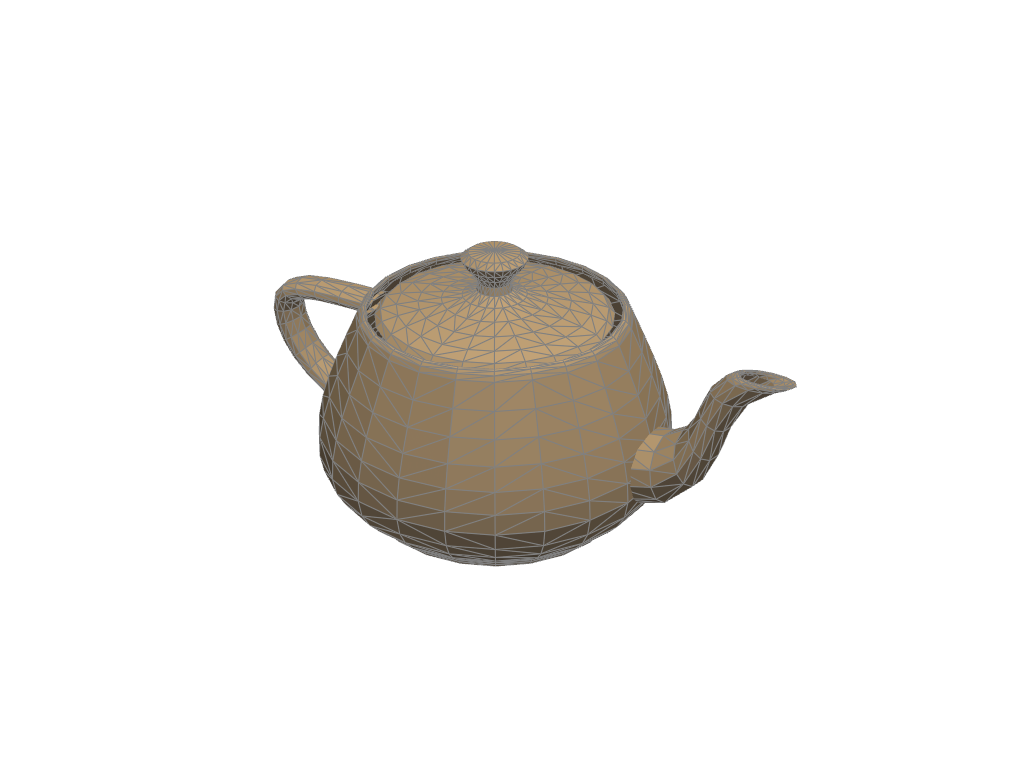

In [40]:
try:
    pv.set_jupyter_backend('static')
    print("Backend postavljen na 'static'.")
except Exception as e:
    print(f"Greška pri postavljanju 'static' backenda: {e}")

# Učitaj .obj datoteku
try:
    mesh = pv.read('teapot.obj')

    # Prikaz osnovnih informacija o mreži
    print("Informacije o učitanoj mreži:")
    print(f"  Broj vrhova: {mesh.n_points}")
    # Korištenje preporučenog načina za broj ploha/ćelija
    if hasattr(mesh, 'n_cells'):
        print(f"  Broj ćelija (ploha): {mesh.n_cells}")
    else:
        print(f"  Broj ploha (stari način): {mesh.n_faces}") # Fallback ako n_cells ne postoji
    print(f"  Ograničavajući okvir (bounds): {mesh.bounds}")

    # Kreiraj scenu za prikaz
    # Za 'static' backend, važno je koristiti off_screen=True
    plotter = Plotter(off_screen=True)
    
    plotter.add_mesh(mesh, color='tan', show_edges=True, edge_color='gray', line_width=1)
    
    plotter.camera_position = 'xy'
    plotter.camera.azimuth = 30
    plotter.camera.elevation = 30
    plotter.reset_camera()

    # Prikaži scenu (trebalo bi prikazati statičnu sliku)
    plotter.show()

except FileNotFoundError:
    print("Datoteka 'teapot.obj' nije pronađena. Provjeri putanju.")
except Exception as e:
    print(f"Došlo je do greške prilikom učitavanja ili prikaza: {e}")

In [41]:
# Pretpostavka: 'mesh', 'np', 'lil_matrix', 'diags' su definirani/importirani u prethodnoj ćeliji.

if 'mesh' in locals() and mesh is not None:
    n_points = mesh.n_points
else:
    print("GREŠKA: 'mesh' objekt nije definiran!")
    n_points = 0 # Zaustavlja daljnje izvođenje ako nema smisla

if n_points > 0:
    adj_matrix = lil_matrix((n_points, n_points), dtype=int)
    edges_object = None # Inicijalizacija

    try:
        edges_object = mesh.extract_all_edges()
    except AttributeError:
        # Alternativni pokušaj ako extract_all_edges() ne postoji
        try:
            edges_object = mesh.extract_feature_edges(boundary_edges=False, 
                                                     feature_edges=False, 
                                                     manifold_edges=False,
                                                     non_manifold_edges=True)
        except AttributeError:
            print("GREŠKA: Nije moguće dohvatiti bridove modela.")

    if edges_object is not None and hasattr(edges_object, 'lines'):
        edges_lines_array = edges_object.lines
        line_idx = 0
        while line_idx < len(edges_lines_array):
            num_points_in_edge = edges_lines_array[line_idx]
            if num_points_in_edge == 2:
                v0_idx = edges_lines_array[line_idx + 1]
                v1_idx = edges_lines_array[line_idx + 2]
                if 0 <= v0_idx < n_points and 0 <= v1_idx < n_points:
                    adj_matrix[v0_idx, v1_idx] = 1
                    adj_matrix[v1_idx, v0_idx] = 1
            line_idx += num_points_in_edge + 1

        adj_matrix_csr = adj_matrix.tocsr()
        print(f"Matrica susjedstva (A): {adj_matrix_csr.shape}, {adj_matrix_csr.nnz} ne-nula el.")

        degrees = np.array(adj_matrix_csr.sum(axis=1)).flatten()
        degree_matrix = diags(degrees, format='csr')
        print(f"Matrica stupnjeva (D): {degree_matrix.shape}")

        laplacian_matrix_symmetric = degree_matrix - adj_matrix_csr
        print(f"Simetrična Laplaceova matrica (Ls): {laplacian_matrix_symmetric.shape}")

        if np.allclose(laplacian_matrix_symmetric.sum(axis=1), 0):
            print("Provjera Ls (suma redaka ~ 0): OK")
        else:
            print("UPOZORENJE: Suma redaka Ls nije 0.")
            
    else:
        if edges_object is None: # Greška je već ispisana za dohvaćanje bridova
             pass
        else: # edges_object postoji, ali nema 'lines' atribut, što je čudno
            print("GREŠKA: Objekt bridova nema 'lines' atribut.")
        laplacian_matrix_symmetric = None 
        
else:
    if 'mesh' in locals() and mesh is not None : # n_points je bio 0
        print("GREŠKA: n_points je 0. Laplaceova matrica nije izračunata.")
    # Ako 'mesh' nije bio definiran, greška je već ispisana
    laplacian_matrix_symmetric = None

Matrica susjedstva (A): (1202, 1202), 6864 ne-nula el.
Matrica stupnjeva (D): (1202, 1202)
Simetrična Laplaceova matrica (Ls): (1202, 1202)
Provjera Ls (suma redaka ~ 0): OK


U prethodnoj programskoj ćeliji izračunata je simetrična Laplaceova matrica ($L_s = D - A$) za učitani 3D model. Ispisane su dimenzije dobivenih matrica: matrice susjedstva $A$, dijagonalne matrice stupnjeva $D$ te same Laplaceove matrice $L_s$. Također je provedena provjera osnovnog svojstva $L_s$ matrice, gdje suma svakog njenog retka treba težiti nuli.

In [42]:

if 'laplacian_matrix_symmetric' in locals() and laplacian_matrix_symmetric is not None:
    print(f"--- Spektralna dekompozicija Ls dimenzija {laplacian_matrix_symmetric.shape} ---")

    # Broj svojstvenih parova za izračun (ako želimo koristiti k_shape=800, trebamo 800+1)
    num_eigenvectors_to_compute = min(801, n_points - 2) 
    
    if num_eigenvectors_to_compute < 1:
        print("GREŠKA: Premalo točaka za izračun svojstvenih vektora.")
        eigenvalues, eigenvectors = None, None # Osiguraj da varijable postoje
    else:
        try:
            eigenvalues, eigenvectors = eigsh(laplacian_matrix_symmetric,
                                              k=num_eigenvectors_to_compute,
                                              which='SA', 
                                              tol=1e-5,
                                              maxiter=n_points*10) # Povećan maxiter za veći k

            print(f"Izračunato {len(eigenvalues)} svojstvenih vrijednosti i {eigenvectors.shape[1]} svojstvenih vektora.")
            # print(f"Prvih 10 svojstvenih vrijednosti: {eigenvalues[:10]}") # Opcionalno za provjeru
            print(f"Dimenzije matrice svojstvenih vektora: {eigenvectors.shape}")

        except Exception as e:
            print(f"GREŠKA pri izračunu svojstvenih vrijednosti/vektora: {e}")
            eigenvalues, eigenvectors = None, None # U slučaju greške
else:
    print("GREŠKA: 'laplacian_matrix_symmetric' nije pronađena.")
    eigenvalues, eigenvectors = None, None # Osiguraj da varijable postoje

--- Spektralna dekompozicija Ls dimenzija (1202, 1202) ---
Izračunato 801 svojstvenih vrijednosti i 801 svojstvenih vektora.
Dimenzije matrice svojstvenih vektora: (1202, 801)


U prethodnoj ćeliji provedena je spektralna dekompozicija simetrične Laplaceove matrice $L_s$. Korištenjem funkcije `eigsh` iz biblioteke `scipy.sparse.linalg`, izračunat je specificirani broj najmanjih algebarskih svojstvenih vrijednosti ($\lambda_i$) i odgovarajućih svojstvenih vektora ($\mathbf{e}_i$). Ovi svojstveni parovi ključni su za daljnju spektralnu analizu i aproksimaciju oblika modela. Rezultirajuće svojstvene vrijednosti pohranjene su u varijabli `eigenvalues`, a svojstveni vektori (kao stupci matrice) u varijabli `eigenvectors`.

--- Generiranje aproksimacija (max k_shape=800) ---
Testiram aproksimacije s k=[5, 15, 30, 50, 100, 200, 400, 800].


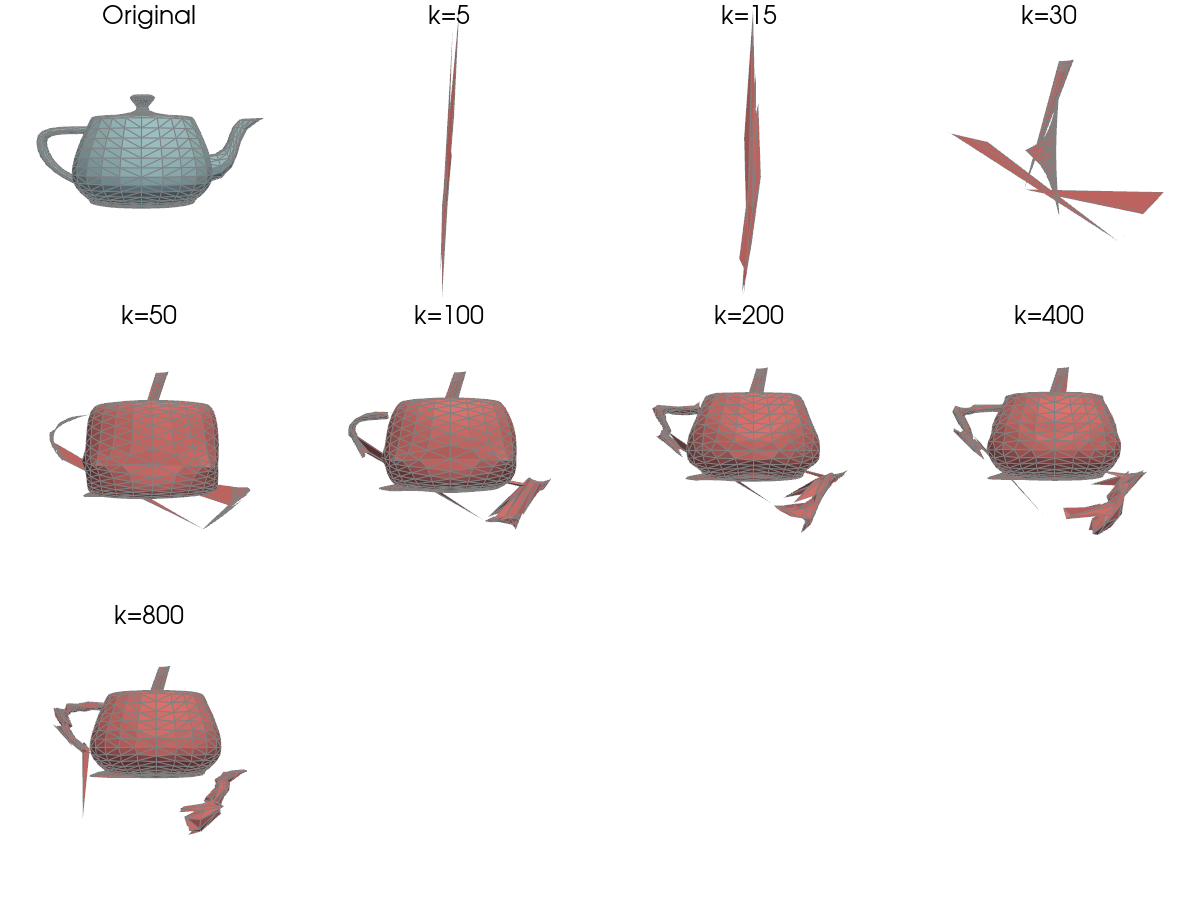

In [43]:

if 'mesh' in locals() and 'eigenvectors' in locals():
    original_coords = mesh.points
    mean_original_coords = np.mean(original_coords, axis=0)
    max_available_for_shape = eigenvectors.shape[1] - 1
    
    print(f"--- Generiranje aproksimacija (max k_shape={max_available_for_shape}) ---")
    
    k_values_to_test_initial = [5, 15, 30, 50, 100, 200, 400, 800] 
    k_values_to_test = sorted(list(set(k for k in k_values_to_test_initial if k > 0 and k <= max_available_for_shape)))

    if not k_values_to_test:
        print(f"GREŠKA: Nema validnih k vrijednosti za testiranje.")
    else:
        print(f"Testiram aproksimacije s k={k_values_to_test}.")

    approximated_meshes = [] 

    for k_shape in k_values_to_test:
        basis_vectors = eigenvectors[:, 1 : k_shape + 1]
        
        coefficients = np.zeros((3, k_shape))
        for i in range(3): 
            coefficients[i, :] = original_coords[:, i].T @ basis_vectors
            
        current_approximated_coords = basis_vectors @ coefficients.T
        current_approximated_coords += mean_original_coords
        
        approx_mesh = mesh.copy()
        approx_mesh.points = current_approximated_coords
        approx_mesh.name = f"k={k_shape}" 
        # approx_mesh.field_data['k_shape_used'] = np.array([k_shape]) # Opcionalno, ako treba za kasnije
        approximated_meshes.append(approx_mesh)
        # print(f"Aproksimacija za k={k_shape} dovršena.") # Može se otkomentirati za praćenje

    # Vizualizacija modela
    if approximated_meshes:
        try:
            pv.set_jupyter_backend('static')
            num_plots = len(approximated_meshes) + 1
            
            if num_plots <= 2: plot_shape = (1, num_plots)
            elif num_plots == 3: plot_shape = (1, 3)
            elif num_plots == 4: plot_shape = (2, 2)
            elif num_plots <= 6: plot_shape = (2, 3)
            elif num_plots <= 8: plot_shape = (2, 4)
            else: plot_shape = ((num_plots + 3) // 4, 4)

            plotter = pv.Plotter(shape=plot_shape, border=False)
            plotter.subplot(0, 0)
            plotter.add_text("Original", font_size=10, position='upper_edge', shadow=True)
            plotter.add_mesh(mesh, color='lightblue', show_edges=True, edge_color='gray', line_width=0.5)
            plotter.camera_position = 'xy'; plotter.reset_camera()

            current_idx = 0
            for r_plot in range(plot_shape[0]):
                for c_plot in range(plot_shape[1]):
                    if r_plot == 0 and c_plot == 0: continue
                    if current_idx < len(approximated_meshes):
                        plotter.subplot(r_plot, c_plot)
                        plotter.add_text(approximated_meshes[current_idx].name, font_size=10, position='upper_edge', shadow=True)
                        plotter.add_mesh(approximated_meshes[current_idx], color='lightcoral', show_edges=True, edge_color='gray', line_width=0.5)
                        plotter.camera_position = 'xy'; plotter.reset_camera()
                        current_idx += 1
            
            # plotter.link_views() # Nije presudno za static prikaz
            window_width = max(1200, plot_shape[1] * 300)
            window_height = plot_shape[0] * 300
            plotter.show(window_size=[window_width, window_height])
        except Exception as e:
            print(f"GREŠKA pri PyVista vizualizaciji: {e}")
    elif k_values_to_test: # Ako ima k_values ali lista approximated_meshes je prazna (npr. greška u petlji)
        print("Nema generiranih aproksimiranih mreža za vizualizaciju.")
        
else:
    print("GREŠKA: 'mesh' ili 'eigenvectors' objekt nije pronađen.")

Nakon izračuna svojstvenih vektora, u prethodnoj ćeliji generirane su aproksimacije originalnog 3D modela. Korišten je različit broj $k$ svojstvenih vektora (koji odgovaraju najmanjim ne-nultim svojstvenim vrijednostima) za rekonstrukciju koordinata vrhova. Svaka aproksimacija je stvorena projekcijom originalnih koordinata na odabrane svojstvene vektore te zatim rekonstrukcijom iz tih koeficijenata. Na kraju je napravljena vizualna usporedba originalnog modela i dobivenih aproksimacija pomoću biblioteke `pyvista`, prikazujući kako se kvaliteta aproksimacije mijenja s brojem korištenih svojstvenih vektora.

--- Izračun RMSE grešaka i crtanje grafa ---
Za k=5, RMSE: 2.021467
Za k=15, RMSE: 2.024084
Za k=30, RMSE: 1.798546
Za k=50, RMSE: 1.384435
Za k=100, RMSE: 1.372738
Za k=200, RMSE: 1.365949
Za k=400, RMSE: 1.358634
Za k=800, RMSE: 1.352224


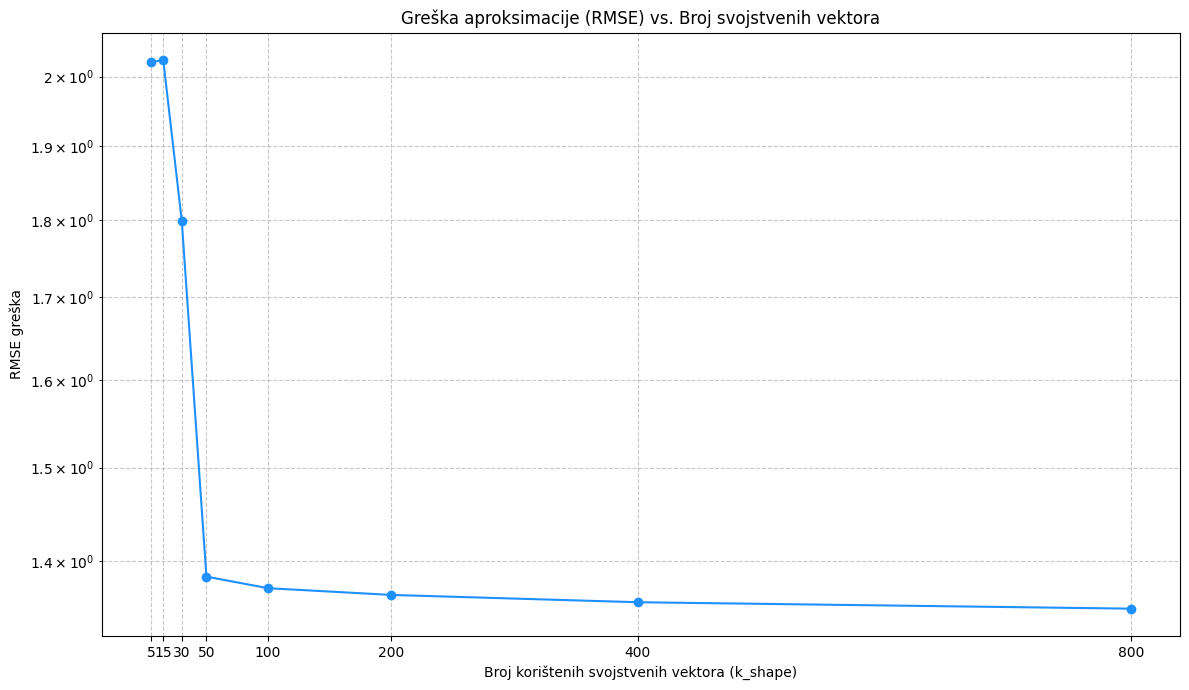

In [44]:
if ('original_coords' in locals() and 
    'approximated_meshes' in locals() and 
    'k_values_to_test' in locals() and
    len(approximated_meshes) == len(k_values_to_test)):

    print("--- Izračun RMSE grešaka i crtanje grafa ---")
    rmse_errors = []

    for i, approx_mesh in enumerate(approximated_meshes):
        k_shape = k_values_to_test[i]
        current_approximated_coords = approx_mesh.points
        
        squared_errors = np.sum((original_coords - current_approximated_coords)**2, axis=1)
        mean_squared_error = np.mean(squared_errors)
        rmse = np.sqrt(mean_squared_error)
        rmse_errors.append(rmse)
        print(f"Za k={k_shape}, RMSE: {rmse:.6f}")

    # Crtanje grafa RMSE greške
    if k_values_to_test and rmse_errors:
        plt.figure(figsize=(12, 7))
        plt.plot(k_values_to_test, rmse_errors, marker='o', linestyle='-', color='dodgerblue')
        plt.xlabel("Broj korištenih svojstvenih vektora (k_shape)")
        plt.ylabel("RMSE greška")
        plt.yscale('log') # Logaritamska skala za y-os
        plt.title("Greška aproksimacije (RMSE) vs. Broj svojstvenih vektora")
        plt.grid(True, which="both", linestyle='--', alpha=0.7)

        if len(k_values_to_test) <= 12:
             plt.xticks(k_values_to_test)
        else:
             tick_indices = np.linspace(0, len(k_values_to_test) - 1, 10, dtype=int)
             plt.xticks([k_values_to_test[i] for i in tick_indices])
        
        plt.tight_layout()
        plt.show()
    else:
        print("Nema podataka za crtanje grafa greške.")
else:
    print("GREŠKA: Potrebne varijable nisu ispravno definirane. Izvrši prethodnu ćeliju.")

U prethodnoj programskoj ćeliji izvršena je kvantitativna analiza greške za generirane aproksimacije 3D modela. Za svaku aproksimaciju, izračunata je korijenska vrijednost prosječne kvadratne greške (RMSE) usporedbom koordinata vrhova aproksimiranog modela s originalnim. Rezultati su prikazani na grafikonu koji ilustrira ovisnost RMSE greške o broju $k$ korištenih svojstvenih vektora. Logaritamska skala na y-osi korištena je za bolju vizualizaciju opadanja greške.

--- Vizualizacija odabranih svojstvenih vektora ---
Prikazujem svojstvene vektore s indeksima stupaca: [1, 10, 50, 100]


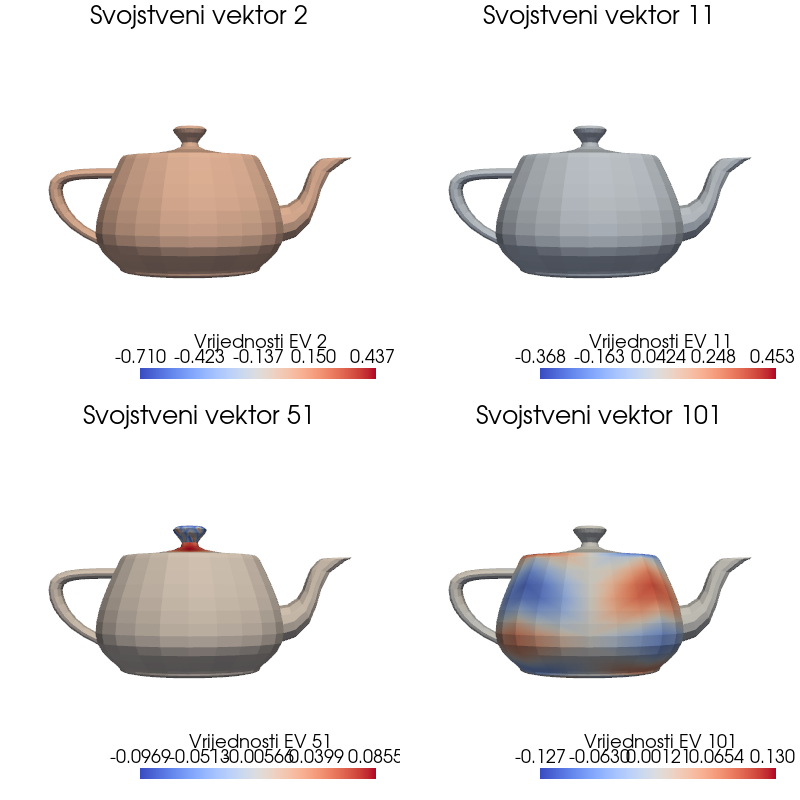

In [45]:
# Pretpostavka: 'mesh', 'eigenvectors', 'pv', 'np' su definirani/importirani.

if 'mesh' in locals() and 'eigenvectors' in locals():
    print("--- Vizualizacija odabranih svojstvenih vektora ---")
    
    max_eigenvector_idx_available = eigenvectors.shape[1] - 1
    indices_to_visualize = sorted(list(set([
        1, 
        min(10, max_eigenvector_idx_available),
        min(50, max_eigenvector_idx_available),
        min(100, max_eigenvector_idx_available)
    ])))
    indices_to_visualize = [idx for idx in indices_to_visualize if idx <= max_eigenvector_idx_available and idx > 0] # Osiguraj >0

    if not indices_to_visualize:
        print("GREŠKA: Nema validnih indeksa svojstvenih vektora za prikaz.")
    else:
        print(f"Prikazujem svojstvene vektore s indeksima stupaca: {indices_to_visualize}")
        try:
            pv.set_jupyter_backend('static')
            num_plots = len(indices_to_visualize)
            if num_plots == 0: raise ValueError("Lista 'indices_to_visualize' je prazna.")

            if num_plots == 1: plot_shape = (1,1)
            elif num_plots == 2: plot_shape = (1,2)
            elif num_plots == 3: plot_shape = (1,3)
            elif num_plots == 4: plot_shape = (2,2)
            else: plot_shape = (2, (num_plots + 1) // 2)

            plotter = pv.Plotter(shape=plot_shape, border=False)
            current_plot_r, current_plot_c = 0, 0

            for eigen_idx in indices_to_visualize:
                mesh_copy = mesh.copy()
                scalar_data_name = f'Eigenvector_{eigen_idx+1}'
                mesh_copy[scalar_data_name] = eigenvectors[:, eigen_idx]

                plotter.subplot(current_plot_r, current_plot_c)
                plotter.add_text(f"Svojstveni vektor {eigen_idx+1}", font_size=10, position='upper_edge', shadow=True)
                plotter.add_mesh(mesh_copy, scalars=scalar_data_name, cmap='coolwarm', 
                                 scalar_bar_args={'title': f'Vrijednosti EV {eigen_idx+1}'})
                plotter.camera_position = 'xy'; plotter.reset_camera()
                
                current_plot_c += 1
                if current_plot_c >= plot_shape[1]:
                    current_plot_c = 0
                    current_plot_r += 1
            
            plotter.show(window_size=[plot_shape[1]*400, plot_shape[0]*400])

        except Exception as e:
            print(f"GREŠKA prilikom vizualizacije svojstvenih vektora: {e}")
else:
    print("GREŠKA: 'mesh' ili 'eigenvectors' objekt nije pronađen.")

### Tumačenje Vizualizacije Svojstvenih Vektora

Gornji prikazi ilustriraju kako odabrani svojstveni vektori (eigenvectors) Laplaceove matrice variraju preko površine našeg 3D modela (čajnika). Svaki svojstveni vektor može se shvatiti kao fundamentalni "oblik" ili "mod vibracije" mreže. Vrijednosti svojstvenog vektora su prikazane bojama: područja s visokim vrijednostima mogu biti obojena jednom bojom (npr. crveno), a područja s niskim vrijednostima drugom (npr. plavo), s glatkim prijelazima između.

**Ključna zapažanja:**

* **Svojstveni vektori s malim indeksima (npr., Vektor 2, Vektor 11):** Ovi vektori odgovaraju malim svojstvenim vrijednostima. Na vizualizaciji se očituju kao **glatke, globalne promjene** skalarnog polja preko cijele površine. Oni hvataju osnovne, grube karakteristike oblika. Prvi ne-trivijalni svojstveni vektor (indeks 1, tj. naš "Vektor 2") često pokazuje najjednostavniju moguću glatku varijaciju.
* **Svojstveni vektori s većim indeksima (npr., Vektor 51, Vektor 101):** Kako se indeks svojstvenog vektora (i odgovarajuća svojstvena vrijednost) povećava, prikazani uzorci postaju **kompleksniji, s više oscilacija i finijih detalja**. Ovi vektori opisuju lokalne varijacije i detalje više frekvencije na površini.

**Povezanost s Aproksimacijom:**

Metoda spektralne aproksimacije, koju smo ranije implementirali, koristi upravo ove svojstvene vektore kao **bazne funkcije**. Originalne koordinate modela se projiciraju na odabrani podskup ovih baznih funkcija (obično onih s najmanjim svojstvenim vrijednostima/indeksima). Rekonstrukcija se zatim vrši kao ponderirana suma tih odabranih svojstvenih vektora.

Kada za aproksimaciju koristimo samo mali broj prvih (glatkih) svojstvenih vektora, dobivamo aproksimaciju koja zadržava globalni oblik, ali gubi fine detalje. Dodavanjem sve više svojstvenih vektora (s višim frekvencijama), postupno vraćamo te finije detalje u aproksimirani model, što smo vidjeli na RMSE grafu i vizualnoj usporedbi aproksimacija.

Ovi svojstveni vektori čine ortonormiranu bazu (ako su pravilno normalizirani, što `eigsh` obično radi) za prostor funkcija definiranih na vrhovima mreže.

--- Analiza spektra svojstvenih vrijednosti i energije koeficijenata ---


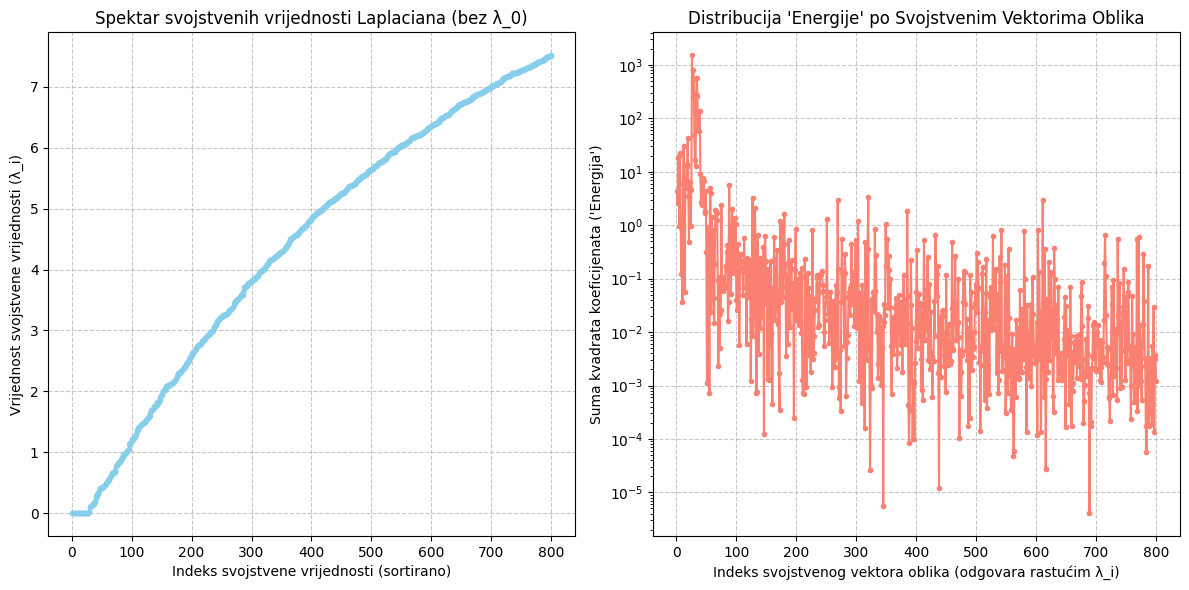

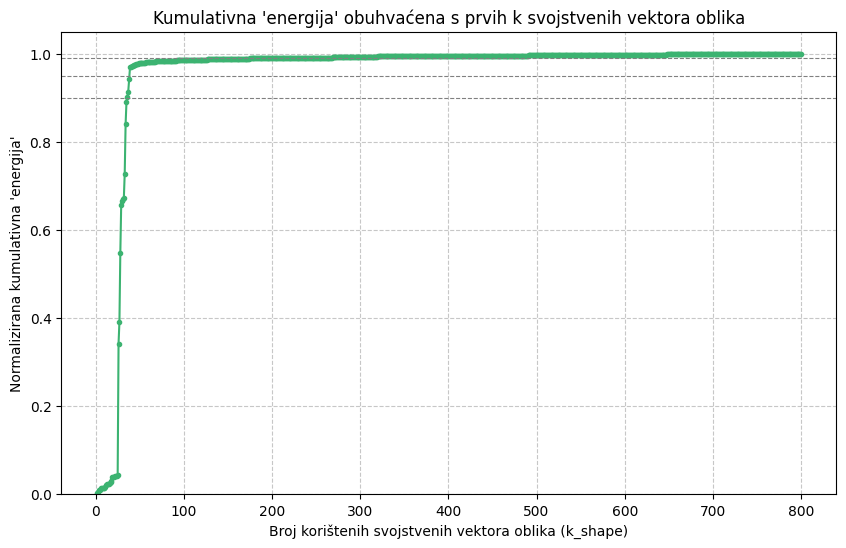

In [46]:

if ('eigenvalues' in locals() and 
    'eigenvectors' in locals() and 
    'original_coords' in locals() and
    'mesh' in locals()):

    print("--- Analiza spektra svojstvenih vrijednosti i energije koeficijenata ---")
    n_points = mesh.n_points

    # 1. Prikaz spektra svojstvenih vrijednosti
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1) # Dva grafa jedan pored drugog
    # Prikazujemo sve izračunate svojstvene vrijednosti
    # Prva je blizu nule, pa možeš prikazati od druge ako želiš vidjeti ostale bolje
    relevant_eigenvalues = eigenvalues[1:] # Preskačemo prvu (~0) za bolji prikaz skale ostalih
    indices = np.arange(1, len(relevant_eigenvalues) + 1)
    
    plt.plot(indices, relevant_eigenvalues, marker='.', linestyle='-', color='skyblue')
    plt.xlabel("Indeks svojstvene vrijednosti (sortirano)")
    plt.ylabel("Vrijednost svojstvene vrijednosti (λ_i)")
    plt.title("Spektar svojstvenih vrijednosti Laplaciana (bez λ_0)")
    plt.grid(True, linestyle='--', alpha=0.7)
    # Možeš koristiti log skalu ako vrijednosti brzo rastu
    # plt.yscale('log')


    # 2. Prikaz energije (kvadrata magnituda) koeficijenata projekcije
    # Koristit ćemo sve dostupne svojstvene vektore za oblik (preskačemo prvi)
    shape_basis_vectors = eigenvectors[:, 1:] # Svi stupci osim prvog
    
    # Izračunaj koeficijente za x, y, z koordinate na ovoj punoj bazi
    coeffs_x = original_coords[:, 0].T @ shape_basis_vectors
    coeffs_y = original_coords[:, 1].T @ shape_basis_vectors
    coeffs_z = original_coords[:, 2].T @ shape_basis_vectors
    
    # Energija za svaku komponentu i ukupna energija po svojstvenom vektoru
    energy_x = coeffs_x**2
    energy_y = coeffs_y**2
    energy_z = coeffs_z**2
    total_energy_per_mode = energy_x + energy_y + energy_z # Energija za svaki mod/svojstveni vektor

    plt.subplot(1, 2, 2)
    indices_coeffs = np.arange(len(total_energy_per_mode)) # Od 0 do broja modova - 1

    plt.plot(indices_coeffs + 1, total_energy_per_mode, marker='.', linestyle='-', color='salmon') # +1 da indeksi počnu od 1
    plt.xlabel("Indeks svojstvenog vektora oblika (odgovara rastućim λ_i)")
    plt.ylabel("Suma kvadrata koeficijenata ('Energija')")
    plt.title("Distribucija 'Energije' po Svojstvenim Vektorima Oblika")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.yscale('log') # Logaritamska skala je ovdje često korisna da se vide manje vrijednosti

    plt.tight_layout()
    plt.show()
    
    # Dodatno: Kumulativna energija
    cumulative_energy = np.cumsum(total_energy_per_mode)
    normalized_cumulative_energy = cumulative_energy / cumulative_energy[-1] # Normaliziraj na 1

    plt.figure(figsize=(10, 6))
    plt.plot(indices_coeffs + 1, normalized_cumulative_energy, marker='.', linestyle='-', color='mediumseagreen')
    plt.xlabel("Broj korištenih svojstvenih vektora oblika (k_shape)")
    plt.ylabel("Normalizirana kumulativna 'energija'")
    plt.title("Kumulativna 'energija' obuhvaćena s prvih k svojstvenih vektora oblika")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(0.9, color='grey', linestyle='--', lw=0.8) # Linija za 90% energije
    plt.axhline(0.95, color='grey', linestyle='--', lw=0.8) # Linija za 95% energije
    plt.axhline(0.99, color='grey', linestyle='--', lw=0.8) # Linija za 99% energije
    plt.ylim(0, 1.05)
    plt.show()


else:
    print("Greška: Potrebne varijable ('eigenvalues', 'eigenvectors', 'original_coords', 'mesh') nisu sve definirane.")

### Analiza Spektra Svojstvenih Vrijednosti i Distribucije "Energije" Koeficijenata

Prethodni grafovi pružaju dodatni uvid u svojstva Laplaceove matrice našeg modela i kako se informacije o obliku distribuiraju među njenim svojstvenim vektorima.

**1. Spektar Svojstvenih Vrijednosti (λ_i):**
Prvi graf prikazuje sortirane svojstvene vrijednosti Laplaciana (često se prva, koja je približno nula, izostavlja radi bolje preglednosti ostalih). Ove vrijednosti se mogu interpretirati kao kvadrati "frekvencija" mreže. Vidimo kako vrijednosti rastu. Brzina rasta i distribucija ovih vrijednosti mogu otkriti nešto o strukturi mreže. Za mnoge prirodne oblike, svojstvene vrijednosti rastu relativno brzo, što znači da postoji mnogo modova s visokim frekvencijama.

**2. Distribucija "Energije" po Svojstvenim Vektorima Oblika:**
Drugi graf prikazuje sumu kvadrata koeficijenata projekcije originalnih (x, y, z) koordinata na svaki od svojstvenih vektora oblika (preskočili smo prvi svojstveni vektor koji odgovara translaciji). Ova suma kvadrata koeficijenata može se smatrati "energijom" koju originalni oblik ima u smjeru tog specifičnog svojstvenog vektora.
Očekivano je da će **većina energije biti koncentrirana u prvih nekoliko svojstvenih vektora oblika**. To su oni koji odgovaraju najmanjim ne-nultim svojstvenim vrijednostima (najnižim frekvencijama) i opisuju globalne, glatke karakteristike oblika. Kako idemo prema svojstvenim vektorima viših frekvencija, njihov doprinos ukupnoj energiji (tj. magnituda njihovih koeficijenata) obično opada. Logaritamska skala na y-osi pomaže da se vide i manje vrijednosti energije za modove viših frekvencija.

**3. Kumulativna "Energija":**
Treći graf prikazuje normaliziranu kumulativnu sumu "energije" koeficijenata. On pokazuje koliki postotak ukupne "energije" (varijance oblika) je obuhvaćen korištenjem prvih `k` svojstvenih vektora oblika. Na primjer, možemo vidjeti koliko je vektora potrebno da bi se obuhvatilo 90%, 95% ili 99% ukupne energije. Ovo je vrlo slično konceptu "explained variance" u analizi glavnih komponenata (PCA). Ovaj graf jasno demonstrira zašto aproksimacija s relativno malim brojem svojstvenih vektora može biti vrlo uspješna – jer ti prvi vektori nose većinu "signala".

Ova analiza dodatno potvrđuje zašto RMSE greška brzo opada na početku kada dodajemo svojstvene vektore u aproksimaciju: jer dodajemo one koji nose najviše energije/informacija o obliku.

In [47]:
pv.set_jupyter_backend('client')

In [48]:
def spectral_reconstruction(L, coords, k):
    eigvals, eigvecs = eigsh(L, k=k+1, which='SM')
    basis = eigvecs[:, 1:k+1]
    coeffs = basis.T @ coords
    recon = (basis @ coeffs).reshape(-1, 2)
    rmse = np.sqrt(np.mean((coords - recon)**2))
    return recon, rmse

def geometry_aware_reconstruction(L, coords, k, seed=2):
    n = coords.shape[0]
    np.random.seed(seed)
    k_half = k // 2
    random_idx = np.random.choice(n, size=k_half, replace=False)
    last_idx = np.arange(n - k_half, n)
    anchor_idx = np.unique(np.concatenate([random_idx, last_idx]))
    if len(anchor_idx) < k:
        needed = k - len(anchor_idx)
        all_idx = np.arange(n)
        not_selected = np.setdiff1d(all_idx, anchor_idx)
        to_add = not_selected[:needed]
        anchor_idx = np.concatenate([anchor_idx, to_add])
    anchors = coords[anchor_idx]
    anchors_target = anchors + np.random.uniform(-0.1, 0.1, anchors.shape)
    A = L.copy().tolil()
    b = np.zeros_like(coords)
    for i, idx in enumerate(anchor_idx):
        A[idx, :] = 0
        A[idx, idx] = 1
        b[idx] = anchors_target[i]
    recon_x = spsolve(A.tocsr(), b[:, 0])
    recon_y = spsolve(A.tocsr(), b[:, 1])
    recon = np.c_[recon_x, recon_y, np.zeros(n)]
    rmse = np.sqrt(np.mean((coords - recon[:, :2])**2))
    return recon, anchors_target, rmse

n_sides = 25
angles = np.linspace(0, 2 * np.pi, n_sides, endpoint=False)
radii = 1 + 0.3 * np.random.default_rng(42).normal(0, 0.7, n_sides)
radii[7:15] = 1
points_2d = np.c_[radii * np.cos(angles), radii * np.sin(angles)]
points_3d = np.c_[points_2d, np.zeros(n_sides)]
faces = np.concatenate([[n_sides], np.arange(n_sides)])
polygon = pv.PolyData(points_3d, faces)
n = n_sides
adj = lil_matrix((n, n), dtype=int)
for i in range(n):
    adj[i, (i+1)%n] = 1
    adj[(i+1)%n, i] = 1
deg = np.array(adj.sum(axis=1)).flatten()
L = diags(deg) - adj.tocsr()
coords = points_2d


spec_recon_10, rmse_spec_10 = spectral_reconstruction(L, coords, 10)
geom_recon_10, anchors_target_10, rmse_geom_10 = geometry_aware_reconstruction(L, coords, 10)

spec_recon_15, rmse_spec_15 = spectral_reconstruction(L, coords, 15)
geom_recon_15, anchors_target_15, rmse_geom_15 = geometry_aware_reconstruction(L, coords, 15)


lines = np.hstack([[n, *range(n)]])
polyline = pv.PolyData(points_3d)
polyline.lines = lines



p = pv.Plotter(shape=(2, 3), window_size=(1800, 800))
p.add_mesh(polyline, color='gold', line_width=2)
p.subplot(0, 0)
p.add_text("Original polygon", font_size=12)
p.add_mesh(polygon, show_edges=True, color='gold')
p.add_points(points_3d, color='blue', point_size=10)



p.subplot(0, 1)
p.add_text("Spectral (k=10)", font_size=12)
spec_mesh_10 = pv.PolyData(np.c_[spec_recon_10, np.zeros(n)], faces)
p.add_mesh(spec_mesh_10, show_edges=True, color='lightcoral')
p.add_points(np.c_[spec_recon_10, np.zeros(n)], color='blue', point_size=10)
p.add_mesh(polygon, style='wireframe', color='black', line_width=2, opacity=0.7)

p.subplot(0, 2)
p.add_text("Geometry-aware (k=10)", font_size=12)
geom_mesh_10 = pv.PolyData(geom_recon_10, faces)
p.add_mesh(geom_mesh_10, show_edges=True, color='lightblue')
p.add_points(geom_recon_10, color='blue', point_size=10)
p.add_points(np.c_[anchors_target_10, [0]*10], color='red', point_size=20)
p.add_mesh(polygon, style='wireframe', color='black', line_width=2, opacity=0.7)

p.subplot(1, 1)
p.add_text("Spectral (k=15)", font_size=12)
spec_mesh_15 = pv.PolyData(np.c_[spec_recon_15, np.zeros(n)], faces)
p.add_mesh(spec_mesh_15, show_edges=True, color='lightcoral')
p.add_points(np.c_[spec_recon_15, np.zeros(n)], color='blue', point_size=10)
p.add_mesh(polygon, style='wireframe', color='black', line_width=2, opacity=0.7)

p.subplot(1, 2)
p.add_text("Geometry-aware (k=15)", font_size=12)
geom_mesh_15 = pv.PolyData(geom_recon_15, faces)
p.add_mesh(geom_mesh_15, show_edges=True, color='lightblue')
p.add_points(geom_recon_15, color='blue', point_size=10)
p.add_points(np.c_[anchors_target_15, [0]*15], color='red', point_size=20)
p.add_mesh(polygon, style='wireframe', color='black', line_width=2, opacity=0.7)

p.show()



print(f"RMSE (Spectral, k=10):      {rmse_spec_10:.5f}")
print(f"RMSE (Geometry-aware, 10):  {rmse_geom_10:.5f}")
print(f"RMSE (Spectral, k=15):      {rmse_spec_15:.5f}")
print(f"RMSE (Geometry-aware, 15):  {rmse_geom_15:.5f}")

Widget(value='<iframe src="http://localhost:62070/index.html?ui=P_0x32726b4d0_14&reconnect=auto" class="pyvist…

RMSE (Spectral, k=10):      0.09043
RMSE (Geometry-aware, 10):  0.16597
RMSE (Spectral, k=15):      0.06905
RMSE (Geometry-aware, 15):  0.10928


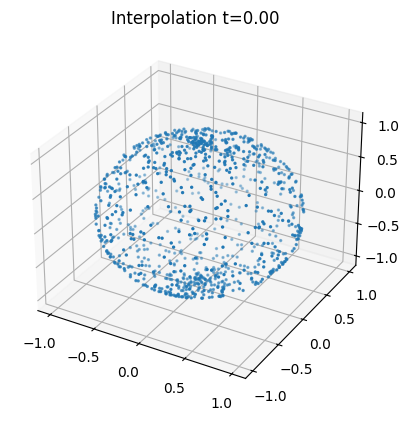

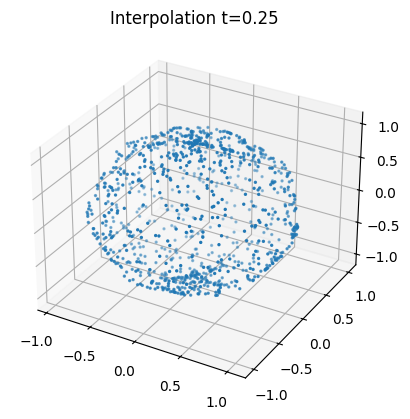

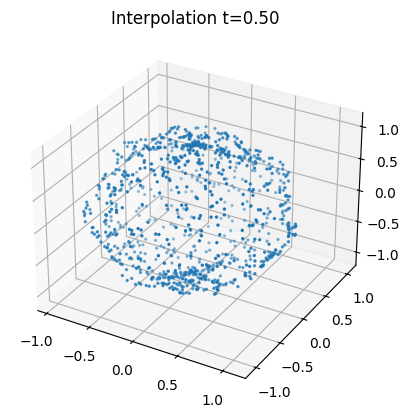

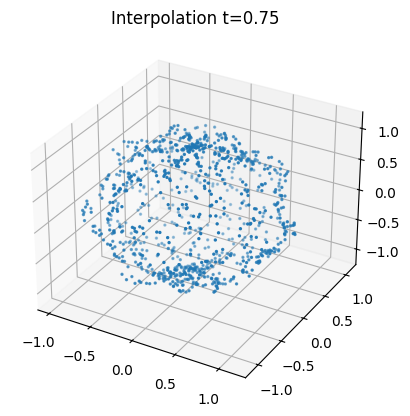

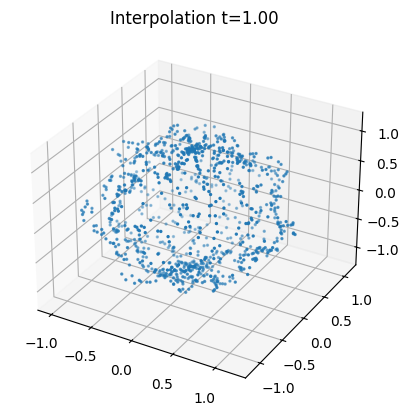

In [49]:
# Generate two synthetic 3D shapes (a sphere and a deformed sphere)
def generate_sphere(n_points=1000, deform=False):
    np.random.seed(42)
    phi = np.random.uniform(0, np.pi, n_points)
    theta = np.random.uniform(0, 2 * np.pi, n_points)
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    points = np.stack((x, y, z), axis=1)
    
    if deform:
        # Apply a simple sinusoidal deformation to simulate a different shape
        deformation = 0.2 * np.sin(5 * phi) * np.cos(5 * theta)
        points[:, 0] += deformation * x
        points[:, 1] += deformation * y
        points[:, 2] += deformation * z

    return points

# Interpolate between two shapes
def interpolate_shapes(shape1, shape2, t):
    return (1 - t) * shape1 + t * shape2

# Visualize the interpolation
def plot_shape(points, title="Shape"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2)
    ax.set_title(title)
    plt.show()

# Generate source and target shapes
shape_a = generate_sphere(deform=False)
shape_b = generate_sphere(deform=True)

# Interpolate for a few values of t
interpolated_shapes = [interpolate_shapes(shape_a, shape_b, t) for t in np.linspace(0, 1, 5)]

# Visualize
for i, shape in enumerate(interpolated_shapes):
    plot_shape(shape, title=f"Interpolation t={i * 0.25:.2f}")


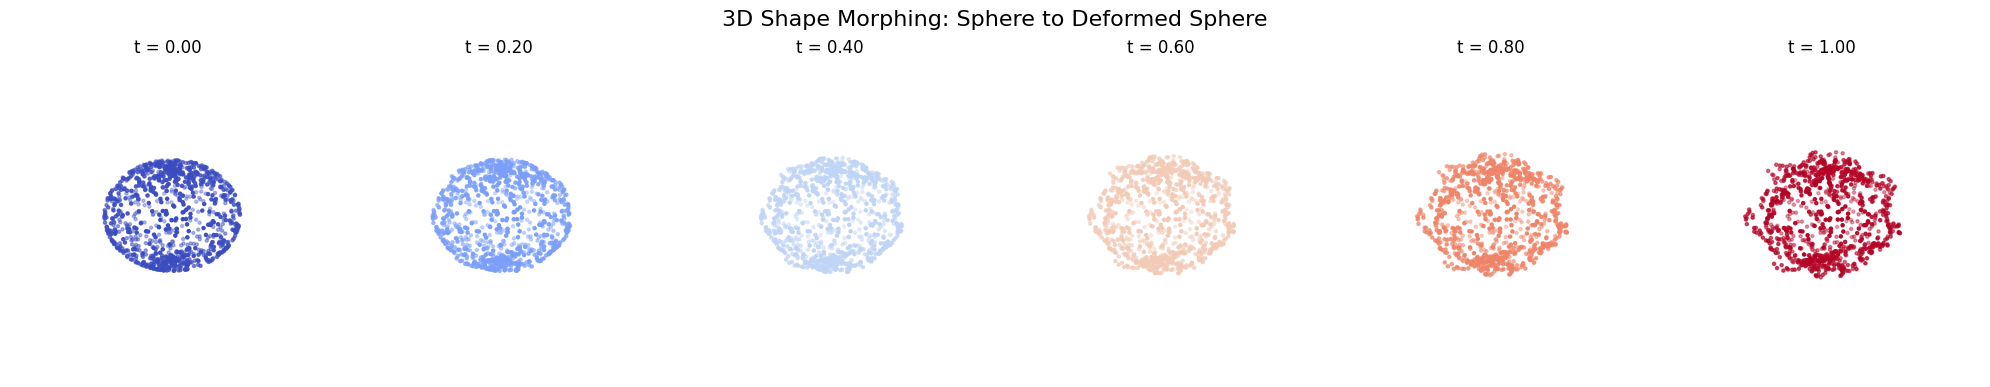

In [51]:
def plot_colored_shape(points, t, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    else:
        fig = None

    # Color by t value (cool to warm transition)
    colors = plt.cm.coolwarm(np.full(points.shape[0], t))

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=5)
    ax.set_title(f"t = {t:.2f}")
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_zlim([-1.5, 1.5])
    ax.axis('off')

    if fig:
        plt.show()

# Plot all interpolated shapes in a single row
fig = plt.figure(figsize=(20, 4))
ts = np.linspace(0, 1, 6)
for i, t in enumerate(ts):
    shape = interpolate_shapes(shape_a, shape_b, t)
    ax = fig.add_subplot(1, len(ts), i + 1, projection='3d')
    plot_colored_shape(shape, t, ax=ax)

plt.suptitle("3D Shape Morphing: Sphere to Deformed Sphere", fontsize=16)
plt.tight_layout()
plt.show()

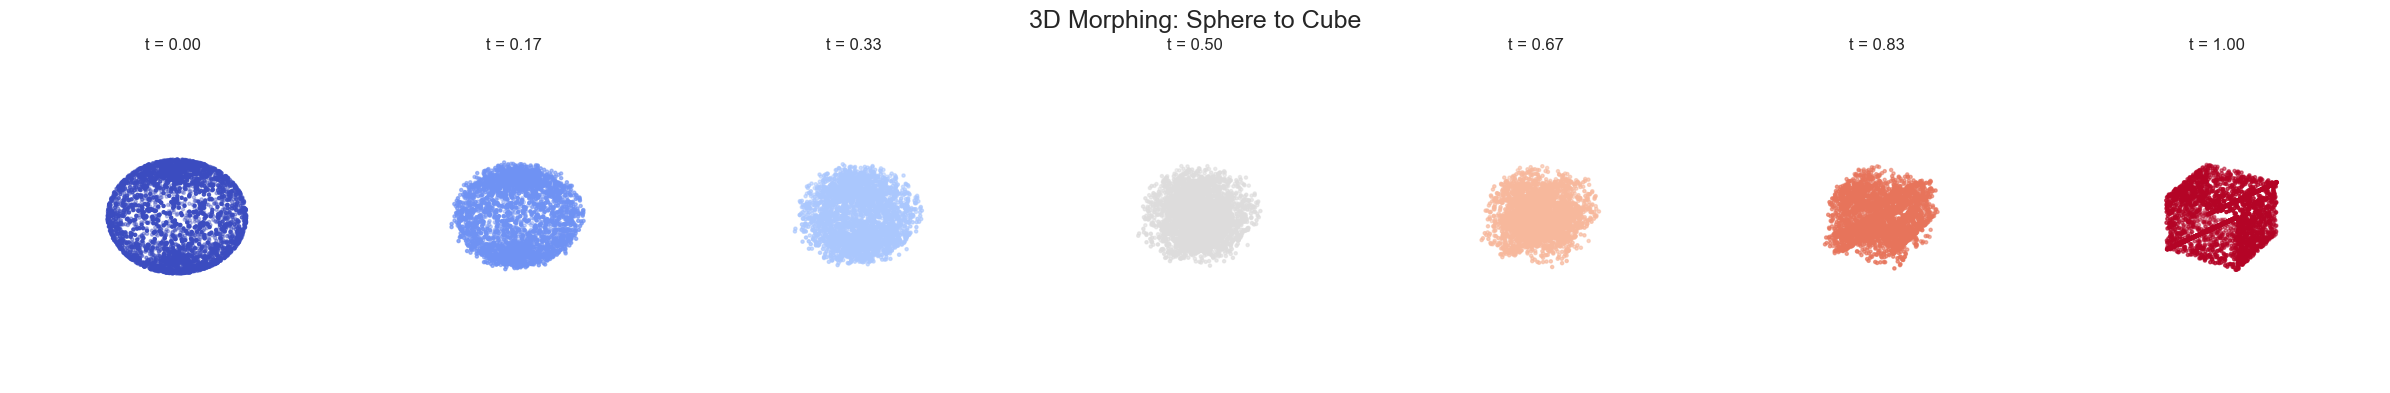

In [57]:
# Generate a point cloud on the surface of a cube
def generate_cube(n_points=1000):
    np.random.seed(42)
    points = []
    faces = [
        ([1, 0, 0], [-1, 0, 0]),
        ([0, 1, 0], [0, -1, 0]),
        ([0, 0, 1], [0, 0, -1])
    ]
    for normal1, normal2 in faces:
        for normal in [normal1, normal2]:
            u = np.random.uniform(-1, 1, n_points // 6)
            v = np.random.uniform(-1, 1, n_points // 6)
            w = np.ones_like(u) * np.sign(normal[0] + normal[1] + normal[2])
            face = np.stack([
                u if normal[0] == 0 else w,
                v if normal[1] == 0 else w,
                u if normal[2] == 0 else w
            ], axis=1)
            points.append(face)
    return np.concatenate(points, axis=0)

# Generate sphere and cube
shape_sphere = generate_sphere(n_points=3000, deform=False)
shape_cube = generate_cube(n_points=3000)

# Normalize both to unit scale
def normalize_shape(shape):
    shape -= shape.mean(axis=0)
    shape /= np.max(np.linalg.norm(shape, axis=1))
    return shape

shape_sphere = normalize_shape(shape_sphere)
shape_cube = normalize_shape(shape_cube)

# Interpolate and plot
fig = plt.figure(figsize=(24, 4))
ts = np.linspace(0, 1, 7)
for i, t in enumerate(ts):
    shape = interpolate_shapes(shape_sphere, shape_cube, t)
    ax = fig.add_subplot(1, len(ts), i + 1, projection='3d')
    plot_colored_shape(shape, t, ax=ax)

plt.suptitle("3D Morphing: Sphere to Cube", fontsize=18)
plt.tight_layout()
plt.show()


In [50]:
print("Preuzimam fsaverage skup podataka...")
fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
print("Preuzimanje završeno.")

brain_files = {
    "Lijeva hemisfera (Pial)": fsaverage.pial_left,
    "Desna hemisfera (Pial)": fsaverage.pial_right,
    "Lijeva hemisfera (Napuhana)": fsaverage.infl_left,
}

Preuzimam fsaverage skup podataka...
Preuzimanje završeno.


In [52]:
def analyze_brain_shape(mesh, k=30):
    """
    Uzima učitani trimesh objekt, računa Laplace-Beltrami operator
    i vraća prvih k svojstvenih vrijednosti i svojstvenih vektora.
    """
    print(f"Analiziram mesh s {len(mesh.vertices)} vrhova...")

    # Računanje Laplaceove matrice
    L = trimesh.smoothing.laplacian_calculation(mesh)

    # Pronađi k svojstvenih vrijednosti i VEKTORA
    try:
        eigenvalues, eigenvectors = eigs(L.astype(float), k=k, which='SM')
    except Exception as e:
        print(f"Greška pri računanju: {e}")
        return None, None

    # Sortiranje rezultata prema svojstvenim vrijednostima
    sorted_indices = np.argsort(np.real(eigenvalues))
    eigenvalues = np.real(eigenvalues[sorted_indices])
    eigenvectors = np.real(eigenvectors[:, sorted_indices])

    print("Analiza završena.")
    return eigenvalues, eigenvectors

# --- Provedba analize i pohrana podataka ---

# Rječnici za pohranu svih podataka
all_meshes = {}
all_shape_dna = {}
all_eigenvectors = {}

for name, path in brain_files.items():
    # 1. Učitaj mesh koristeći nibabel
    img = nib.load(path)
    vertices = img.darrays[0].data
    faces = img.darrays[1].data
    mesh_obj = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Pohrani mesh objekt
    all_meshes[name] = mesh_obj

    # 2. Provedi analizu
    eigenvalues, eigenvectors = analyze_brain_shape(mesh_obj)

    if eigenvalues is not None:
        # Pohrani rezultate
        all_shape_dna[name] = eigenvalues[1:]
        all_eigenvectors[name] = eigenvectors

print("\nSve analize i učitavanje modela su uspješno završeni!")

Analiziram mesh s 10242 vrhova...
Analiza završena.
Analiziram mesh s 10242 vrhova...
Analiza završena.
Analiziram mesh s 10242 vrhova...
Analiza završena.

Sve analize i učitavanje modela su uspješno završeni!


In [53]:
import pyvista as pv

# --- ISPRAVAK: Postavljanje ispravnog backend-a za Jupyter ---
#pv.set_jupyter_backend('client')
# --- KRAJ ISPRAVKA ---

# Kreiranje plotera s 1 redom i 3 stupca za naše modele
plotter = pv.Plotter(shape=(1, 3), window_size=[1500, 500], border=False)

# Prolazimo kroz modele i dodajemo ih na plot
for i, (name, mesh) in enumerate(all_meshes.items()):
    plotter.subplot(0, i)  # Aktiviraj i-ti subplot
    plotter.add_mesh(mesh, color='tan', smooth_shading=True)
    plotter.add_text(name, position='upper_edge', font_size=12, color='white')
    plotter.camera_position = 'xy'

# Poveži kamere tako da se svi modeli rotiraju zajedno
plotter.link_views()

# Prikaži plot
plotter.show()

Widget(value='<iframe src="http://localhost:62070/index.html?ui=P_0x33d4ee210_15&reconnect=auto" class="pyvist…

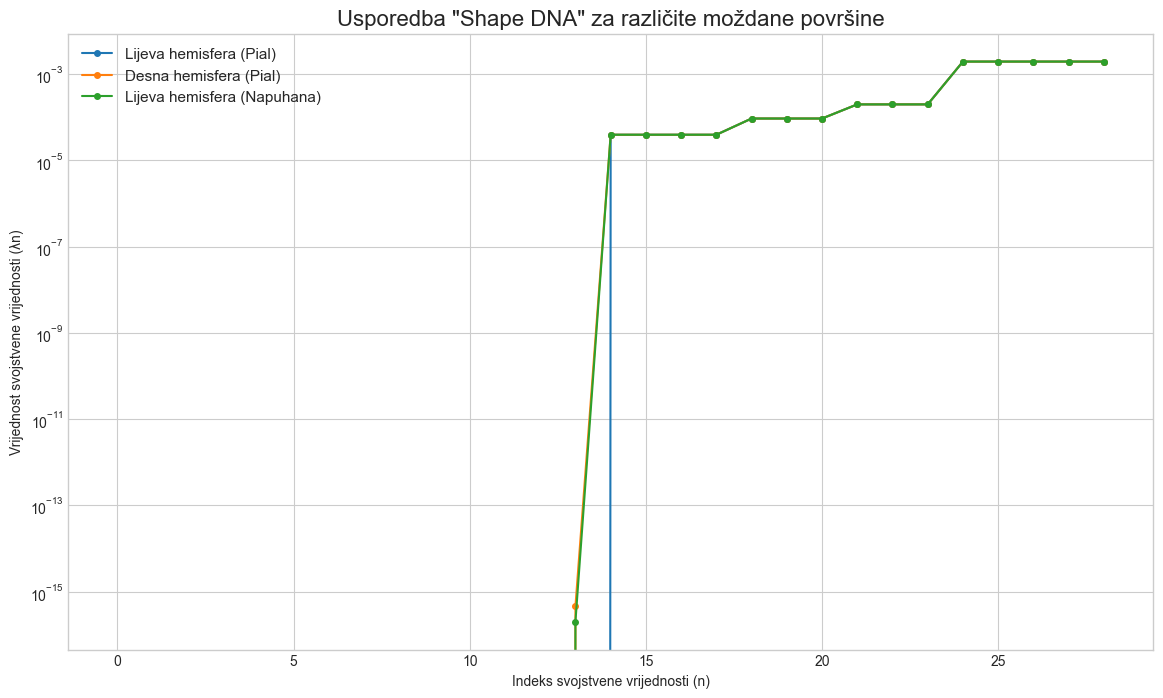

Widget(value='<iframe src="http://localhost:62070/index.html?ui=P_0x33fe54190_17&reconnect=auto" class="pyvist…

In [55]:
# Prvo, graf svojstvenih vrijednosti
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))
for name, dna in all_shape_dna.items():
    plt.plot(dna, marker='o', linestyle='-', markersize=4, label=name)
plt.title('Usporedba "Shape DNA" za različite moždane površine', fontsize=16)
plt.xlabel('Indeks svojstvene vrijednosti (n)'), plt.ylabel('Vrijednost svojstvene vrijednosti (λn)'), plt.legend(fontsize=11), plt.yscale('log')
plt.show()


# Primjer 1: Niskofrekventna svojstvena funkcija
mesh_pial = all_meshes["Lijeva hemisfera (Pial)"]
eigenvectors_pial = all_eigenvectors["Lijeva hemisfera (Pial)"]
eigenfunction_index = 1
plotter = pv.Plotter()
plotter.add_mesh(mesh_pial, scalars=eigenvectors_pial[:, eigenfunction_index], cmap='coolwarm', smooth_shading=True)
plotter.add_scalar_bar(title=f'Svojstvena funkcija {eigenfunction_index}')
plotter.camera_position = 'xy'
plotter.show()

In [56]:
eigenfunction_index = 10
plotter = pv.Plotter()
plotter.add_mesh(mesh_pial, scalars=eigenvectors_pial[:, eigenfunction_index], cmap='coolwarm', smooth_shading=True)
plotter.add_scalar_bar(title=f'Svojstvena funkcija {eigenfunction_index}')
plotter.camera_position = 'xy'
plotter.show()


# Primjer 3: Usporedba iste funkcije na naboranom i napuhanom mozgu
mesh_inflated = all_meshes["Lijeva hemisfera (Napuhana)"]
eigenvectors_inflated = all_eigenvectors["Lijeva hemisfera (Napuhana)"]
eigenfunction_index = 2
plotter = pv.Plotter(shape=(1, 2), window_size=[1200, 500], border=False)
# Naborani (Pial) mozak
plotter.subplot(0, 0)
plotter.add_mesh(mesh_pial, scalars=eigenvectors_pial[:, eigenfunction_index], cmap='coolwarm', smooth_shading=True)
plotter.add_text("Pial (naborani)", color='white')
# Napuhani (Inflated) mozak
plotter.subplot(0, 1)
plotter.add_mesh(mesh_inflated, scalars=eigenvectors_inflated[:, eigenfunction_index], cmap='coolwarm', smooth_shading=True)
plotter.add_text("Inflated (napuhani)", color='white')
plotter.link_views()
plotter.show()

Widget(value='<iframe src="http://localhost:62070/index.html?ui=P_0x33d4ef4d0_18&reconnect=auto" class="pyvist…

Widget(value='<iframe src="http://localhost:62070/index.html?ui=P_0x33d4efc50_19&reconnect=auto" class="pyvist…